In [1]:
import tensorflow as tf

## Create Images Dataset

In [48]:
# load and preprocess image with given path
def load_image(path):
    # path example: xxx\abcd.jpg
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [60, 120], name='captcha')
    image /= 255.0  # normalize to [0,1] range
    return image

# read label 
def get_label(path):
    # path example: b'xxx\abcd.jpg'
    str_path = path.numpy().decode()
    labels = { f'label_{i}': ord(str_path[i-8])-ord('a') for i in range(4) }
    return labels

# image and label generator
def image_label_generator(path_samples):
    for path in path_samples:
        yield load_image(path), get_label(path)
            
# create dataset from generator
def create_dataset_from_path(path_pattern, batch_size=32):            
    # create path dataset
    # by default, tf.data.Dataset.list_files gets filenames in a non-deterministic random shuffled order
    path_ds = tf.data.Dataset.list_files(path_pattern)
  
    # create dataset
    dataset = tf.data.Dataset.from_generator(
        lambda: image_label_generator(path_ds),
        output_types=(tf.float32, { f"label_{i}": tf.int64 for i in range(4) })).batch(batch_size)
    return dataset

In [52]:
# create (image, label) dataset from generator
train_ds = create_dataset_from_path('samples/train/*.jpg', batch_size=32)
test_ds = create_dataset_from_path('samples/test/*.jpg', batch_size=32)
train_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 {'label_0': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
  'label_1': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
  'label_2': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
  'label_3': TensorSpec(shape=<unknown>, dtype=tf.int64, name=None)})

## Show Images in First Batch

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

# get images in first batch
batch_images, batch_labels = next(train_ds.take(1).as_numpy_iterator())

# check shape
print(batch_images.shape) # (batch_size, height, width, channels)
for k,v in batch_labels.items(): # batch_labels is a dict with batch size for each value
    print(k, ' -> ', v.shape) # batch_size

(32, 60, 120, 3)
label_0  ->  (32,)
label_1  ->  (32,)
label_2  ->  (32,)
label_3  ->  (32,)


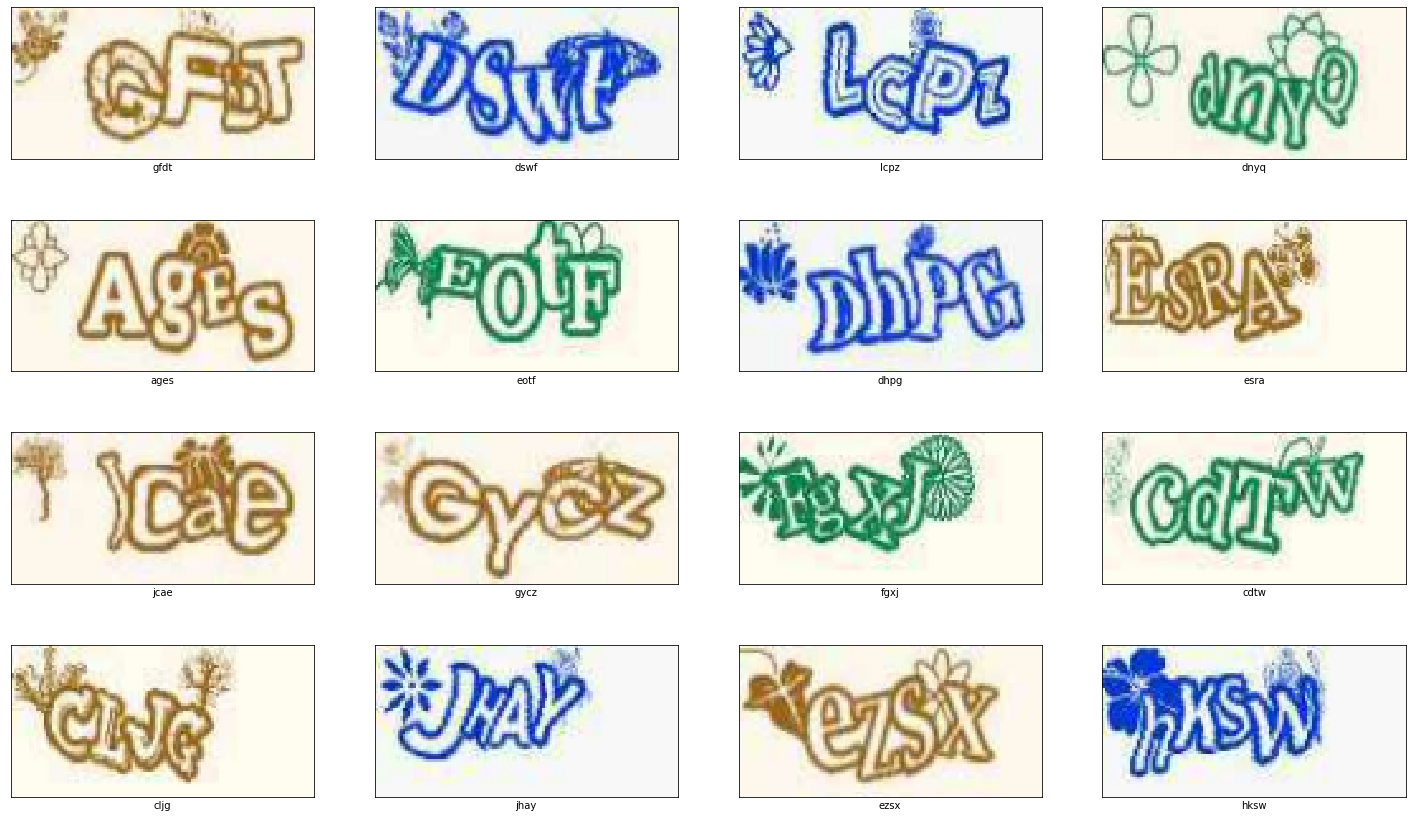

In [54]:
plt.figure(figsize=(25,15)) # width, height
for i,(image,*labels) in enumerate(zip(batch_images, *batch_labels.values()), start=1):
    if i > 16:  break
    plt.subplot(4, 4, i)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(''.join([chr(ord('a') + c) for c in labels]))
plt.show()